In [1]:
using LinearAlgebra
using MatrixDepot
using Kronecker

include group.jl for user defined matrix generators
verify download of index files...
used remote site is https://sparse.tamu.edu/?per_page=All
populating internal database...


In [2]:
using Plots
pyplot()

Plots.PyPlotBackend()

# Poisson Problem in 2D
Please see [DifferentialEquations.jl v1.10 documentation](https://docs.juliadiffeq.org/release-1.10/tutorials/fempoisson_example.html) for reference on analytical and FE solutions of the Posission problem. 

In this example will solve $\Delta u = f$, where $f(x,y) = \sin(2πx)\cos(2πy)$

## Analytical Solution
For this equation we know that the solution is $u(x,y,t)= \sin(2πx)\cos(2πy)/(8π^2)$ with gradient $Du(x,y) = [\cos(2πx)\cos(2πy)/(4π) -\sin(2πx)\sin(2πy)/(4π)]$

In [3]:
N = 40 # number of "interior points" on each side

40

In [4]:
x = y = range(0, stop = 1, length = N)

0.0:0.02564102564102564:1.0

In [5]:
u(x, y) = sin(2*π*x)cos(2*π*y)/(8*π^2)

u (generic function with 1 method)

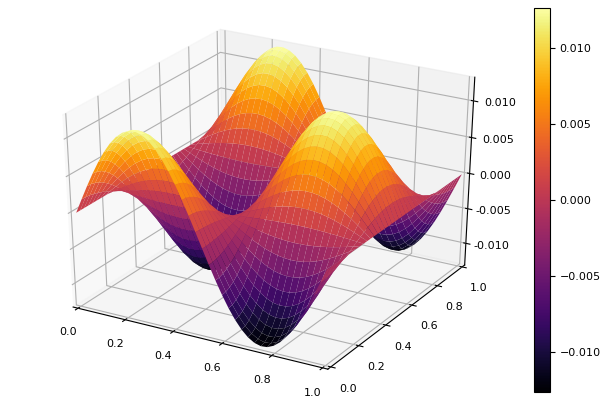

In [6]:
plot(x,y,u, st = [:surface])

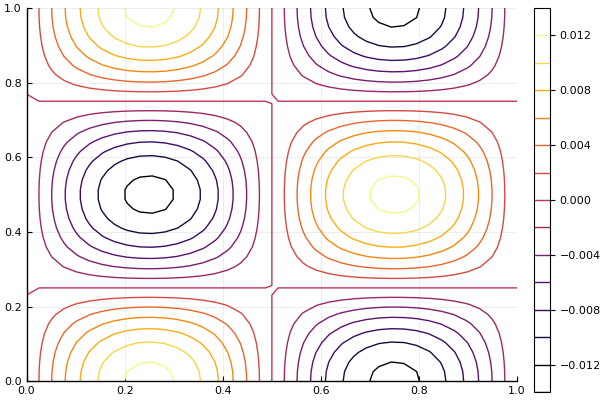

In [7]:
plot(x,y,u, st = [:contour])

## Finite Difference Solution

In [8]:
# Assuming number of subdivisions in x is the same as the number of subdivisions in y, 
# i.e. m = n, and Δx = Δy = h by the convention on p.5 of CS6220 Handout 3 
#
# INCLUDING the boundary, we assume that there are n+1 subdivisions (n+2 vertices) on 
# each axis, since we start at 0 and end at n+1. 
#
# ASSUMPTION: Dirichlet BC at the boundaries means that the field value at the "edge 
# vertices" is zero.
#
# The part of the domain we operate on is size nxn, since we don't operate on the boundaries.
# Because we "unroll", the size of the Laplace operator matrix is n^2 by n^2 
# (see pp. 6-7 of Handout 3)
function laplace_operator2D(n, h)
    A_x = (1.0/h^2)*matrixdepot("tridiag",n)
    I_y = (1.0/h^2)*I(n)
    diag = I(n)
    off_diags = matrixdepot("tridiag",ones(n-1),zeros(n),ones(n-1))
    A = diag ⊗ (A_x + 2*I_y) + off_diags ⊗ -I_y # gives us the NEGATIVE laplacian operator (see CS6220 Handout 3)
    return -A # HACK
end

laplace_operator2D (generic function with 1 method)

We can see below that `laplace_operator2D`, called with $n=3$ gives us the same matrix that is shown on p.7 of CS6220 Handout 3:

In [9]:
laplace_operator2D(3,1)

9×9 Array{Float64,2}:
 -4.0   1.0  -0.0   1.0  -0.0  -0.0  -0.0  -0.0  -0.0
  1.0  -4.0   1.0  -0.0   1.0  -0.0  -0.0  -0.0  -0.0
 -0.0   1.0  -4.0  -0.0  -0.0   1.0  -0.0  -0.0  -0.0
  1.0  -0.0  -0.0  -4.0   1.0  -0.0   1.0  -0.0  -0.0
 -0.0   1.0  -0.0   1.0  -4.0   1.0  -0.0   1.0  -0.0
 -0.0  -0.0   1.0  -0.0   1.0  -4.0  -0.0  -0.0   1.0
 -0.0  -0.0  -0.0   1.0  -0.0  -0.0  -4.0   1.0  -0.0
 -0.0  -0.0  -0.0  -0.0   1.0  -0.0   1.0  -4.0   1.0
 -0.0  -0.0  -0.0  -0.0  -0.0   1.0  -0.0   1.0  -4.0

Recall in our example problem that the RHS is $f(x,y) = \sin(2πx)\cos(2πy)$

In [10]:
f(x,y) = sin(2*π*x)*cos(2*π*y)

f (generic function with 1 method)

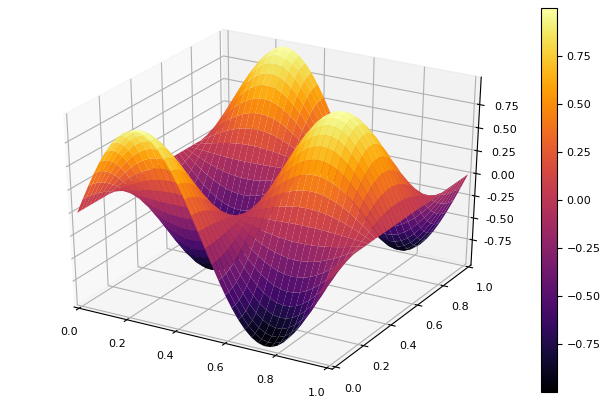

In [11]:
plot(x,y,f, st = [:surface])

In [12]:
h = 1/(N+1) # we assume that side length is 1. Recall that N+1 is the number of intervals

0.024390243902439025

## Test generating the RHS matrix, unrolling, and rerolling

### Generating the RHS matrix, and matrices of x and y positions

In [13]:
function gen_rhs_matrix(N, f::Function, h)
    B = zeros(N,N); # intialize to zero
    
    for i in 1:N
        for j in 1:N
            c = i
            r = (N+1) - j # index that assumes the "bottom" is 1
            B[r,c] = f(i*h,j*h)
        end
    end
    
    return B
end

gen_rhs_matrix (generic function with 1 method)

In [14]:
function gen_2D_positions_x(N, h)
    B = zeros(N,N); # intialize to zero
    
    for i in 1:N
        for j in 1:N
            c = i
            r = (N+1) - j # index that assumes the "bottom" is 1
            B[r,c] = i*h
        end
    end
    
    return B
end

gen_2D_positions_x (generic function with 1 method)

In [15]:
function gen_2D_positions_y(N, h)
    B = zeros(N,N); # intialize to zero
    
    for i in 1:N
        for j in 1:N
            c = i
            r = (N+1) - j # index that assumes the "bottom" is 1
            B[r,c] = j*h
        end
    end
    
    return B
end

gen_2D_positions_y (generic function with 1 method)

In [16]:
rhs_matrix = gen_rhs_matrix(N, f, h)

40×40 Array{Float64,2}:
  0.15086      0.298185    0.43852    …  -0.43852    -0.298185   -0.15086   
  0.145535     0.287659    0.423041      -0.423041   -0.287659   -0.145535  
  0.136799     0.270392    0.397646      -0.397646   -0.270392   -0.136799  
  0.124856     0.246786    0.362931      -0.362931   -0.246786   -0.124856  
  0.109987     0.217396    0.31971       -0.31971    -0.217396   -0.109987  
  0.0925399    0.182911    0.268994   …  -0.268994   -0.182911   -0.0925399 
  0.0729236    0.144138    0.211974      -0.211974   -0.144138   -0.0729236 
  0.051598     0.101987    0.149985      -0.149985   -0.101987   -0.051598  
  0.0290631    0.0574449   0.0844803     -0.0844803  -0.0574449  -0.0290631 
  0.00584688   0.0115567   0.0169957     -0.0169957  -0.0115567  -0.00584688
 -0.0175063   -0.0346024  -0.0508873  …   0.0508873   0.0346024   0.0175063 
 -0.0404492   -0.0799504  -0.117578       0.117578    0.0799504   0.0404492 
 -0.062444    -0.123424   -0.181512       0.181512  

In [17]:
rhs_matrix[N,1]

0.15086029929759615

In [18]:
f(h,h)

0.15086029929759615

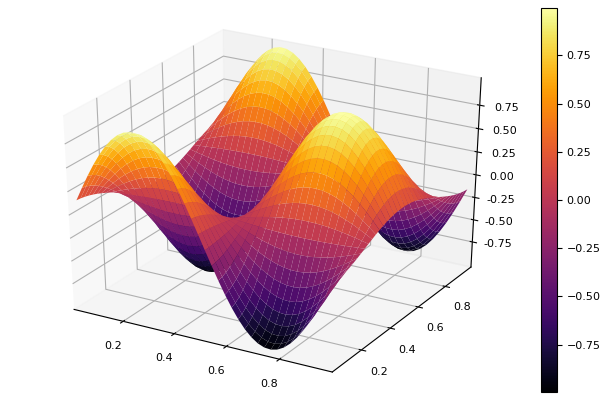

In [19]:
plot(gen_2D_positions_x(N, h), gen_2D_positions_y(N, h), rhs_matrix, st = [:surface])

### Unrolling the RHS matrix

In [20]:
function unroll_RHS(rhs_matrix)
    unrolled = zeros(size(rhs_matrix,1)*size(rhs_matrix,2))
    count = 1
    # NOTE loop order!!!
    # necessary due to our "column major" assumption
    for j in 1:N
        for i in 1:N
            c = i
            r = (N+1) - j # index that assumes the "bottom" is 1
            unrolled[count] = rhs_matrix[r,c]
            count = count + 1
        end
    end
    return unrolled
end

unroll_RHS (generic function with 1 method)

In [21]:
unrolled_rhs = unroll_RHS(rhs_matrix)

1600-element Array{Float64,1}:
  0.15086029929759615
  0.29818456104291713
  0.43851962940690653
  0.5685761693296008 
  0.6853057657460235 
  0.7859723758515921 
  0.868216459626494  
  0.9301102854538987 
  0.9702031145151858 
  0.987555204878265  
  0.9817598382519754 
  0.9529528531181125 
  0.9018094607925454 
  ⋮                  
 -0.9529528531181124 
 -0.9817598382519753 
 -0.9875552048782649 
 -0.9702031145151857 
 -0.9301102854538986 
 -0.8682164596264939 
 -0.7859723758515923 
 -0.6853057657460235 
 -0.5685761693296005 
 -0.43851962940690675
 -0.2981845610429171 
 -0.15086029929759673

Sanity check: the first $N$ elements of the unrolled RHS matrix should match the bottom row of the original RHS matrix.

In [22]:
rhs_matrix[N,:] == unrolled_rhs[1:N]

true

In [23]:
rhs_matrix[N,:] == unrolled_rhs[2:N+1]

false

In [24]:
# below is for just for side-by-side comparison
[rhs_matrix[N,:] unrolled_rhs[1:N]]

40×2 Array{Float64,2}:
  0.15086    0.15086 
  0.298185   0.298185
  0.43852    0.43852 
  0.568576   0.568576
  0.685306   0.685306
  0.785972   0.785972
  0.868216   0.868216
  0.93011    0.93011 
  0.970203   0.970203
  0.987555   0.987555
  0.98176    0.98176 
  0.952953   0.952953
  0.901809   0.901809
  ⋮                  
 -0.952953  -0.952953
 -0.98176   -0.98176 
 -0.987555  -0.987555
 -0.970203  -0.970203
 -0.93011   -0.93011 
 -0.868216  -0.868216
 -0.785972  -0.785972
 -0.685306  -0.685306
 -0.568576  -0.568576
 -0.43852   -0.43852 
 -0.298185  -0.298185
 -0.15086   -0.15086 

### Rerolling

In [25]:
function reroll(unrolled_rhs,N)
    rerolled = zeros(N,N)
    count = 0
    for j in 1:N
        r = (N+1) - j # index that assumes the "bottom" is 1
        starting_idx = count*N+1
        rerolled[r,:] = unrolled_rhs[starting_idx:(starting_idx + N - 1)]
        count = count + 1
    end
    return rerolled
end

reroll (generic function with 1 method)

In [26]:
rerolled = reroll(unrolled_rhs,N)

40×40 Array{Float64,2}:
  0.15086      0.298185    0.43852    …  -0.43852    -0.298185   -0.15086   
  0.145535     0.287659    0.423041      -0.423041   -0.287659   -0.145535  
  0.136799     0.270392    0.397646      -0.397646   -0.270392   -0.136799  
  0.124856     0.246786    0.362931      -0.362931   -0.246786   -0.124856  
  0.109987     0.217396    0.31971       -0.31971    -0.217396   -0.109987  
  0.0925399    0.182911    0.268994   …  -0.268994   -0.182911   -0.0925399 
  0.0729236    0.144138    0.211974      -0.211974   -0.144138   -0.0729236 
  0.051598     0.101987    0.149985      -0.149985   -0.101987   -0.051598  
  0.0290631    0.0574449   0.0844803     -0.0844803  -0.0574449  -0.0290631 
  0.00584688   0.0115567   0.0169957     -0.0169957  -0.0115567  -0.00584688
 -0.0175063   -0.0346024  -0.0508873  …   0.0508873   0.0346024   0.0175063 
 -0.0404492   -0.0799504  -0.117578       0.117578    0.0799504   0.0404492 
 -0.062444    -0.123424   -0.181512       0.181512  

**Sanity check:** The "rerolled" matrix should be the same as the "unrolled" matrix:

In [27]:
rerolled == rhs_matrix

true

In [28]:
rerolled

40×40 Array{Float64,2}:
  0.15086      0.298185    0.43852    …  -0.43852    -0.298185   -0.15086   
  0.145535     0.287659    0.423041      -0.423041   -0.287659   -0.145535  
  0.136799     0.270392    0.397646      -0.397646   -0.270392   -0.136799  
  0.124856     0.246786    0.362931      -0.362931   -0.246786   -0.124856  
  0.109987     0.217396    0.31971       -0.31971    -0.217396   -0.109987  
  0.0925399    0.182911    0.268994   …  -0.268994   -0.182911   -0.0925399 
  0.0729236    0.144138    0.211974      -0.211974   -0.144138   -0.0729236 
  0.051598     0.101987    0.149985      -0.149985   -0.101987   -0.051598  
  0.0290631    0.0574449   0.0844803     -0.0844803  -0.0574449  -0.0290631 
  0.00584688   0.0115567   0.0169957     -0.0169957  -0.0115567  -0.00584688
 -0.0175063   -0.0346024  -0.0508873  …   0.0508873   0.0346024   0.0175063 
 -0.0404492   -0.0799504  -0.117578       0.117578    0.0799504   0.0404492 
 -0.062444    -0.123424   -0.181512       0.181512  

In [29]:
rhs_matrix

40×40 Array{Float64,2}:
  0.15086      0.298185    0.43852    …  -0.43852    -0.298185   -0.15086   
  0.145535     0.287659    0.423041      -0.423041   -0.287659   -0.145535  
  0.136799     0.270392    0.397646      -0.397646   -0.270392   -0.136799  
  0.124856     0.246786    0.362931      -0.362931   -0.246786   -0.124856  
  0.109987     0.217396    0.31971       -0.31971    -0.217396   -0.109987  
  0.0925399    0.182911    0.268994   …  -0.268994   -0.182911   -0.0925399 
  0.0729236    0.144138    0.211974      -0.211974   -0.144138   -0.0729236 
  0.051598     0.101987    0.149985      -0.149985   -0.101987   -0.051598  
  0.0290631    0.0574449   0.0844803     -0.0844803  -0.0574449  -0.0290631 
  0.00584688   0.0115567   0.0169957     -0.0169957  -0.0115567  -0.00584688
 -0.0175063   -0.0346024  -0.0508873  …   0.0508873   0.0346024   0.0175063 
 -0.0404492   -0.0799504  -0.117578       0.117578    0.0799504   0.0404492 
 -0.062444    -0.123424   -0.181512       0.181512  

### Example with `simple_rhs`

In [30]:
h = 2/(N+1) # we assume that side length is 2. Recall that N+1 is the number of intervals

0.04878048780487805

In [31]:
A = laplace_operator2D(N,h)

1600×1600 Array{Float64,2}:
 -1681.0     420.25     -0.0      -0.0   …     -0.0      -0.0      -0.0 
   420.25  -1681.0     420.25     -0.0         -0.0      -0.0      -0.0 
    -0.0     420.25  -1681.0     420.25        -0.0      -0.0      -0.0 
    -0.0      -0.0     420.25  -1681.0         -0.0      -0.0      -0.0 
    -0.0      -0.0      -0.0     420.25        -0.0      -0.0      -0.0 
    -0.0      -0.0      -0.0      -0.0   …     -0.0      -0.0      -0.0 
    -0.0      -0.0      -0.0      -0.0         -0.0      -0.0      -0.0 
    -0.0      -0.0      -0.0      -0.0         -0.0      -0.0      -0.0 
    -0.0      -0.0      -0.0      -0.0         -0.0      -0.0      -0.0 
    -0.0      -0.0      -0.0      -0.0         -0.0      -0.0      -0.0 
    -0.0      -0.0      -0.0      -0.0   …     -0.0      -0.0      -0.0 
    -0.0      -0.0      -0.0      -0.0         -0.0      -0.0      -0.0 
    -0.0      -0.0      -0.0      -0.0         -0.0      -0.0      -0.0 
     ⋮                 

In [32]:
size(A)

(1600, 1600)

This `simple_rhs` comes from the analytical solution in Figure 1.1 / Example 1.1.1 of [these notes from ETHZ](http://people.inf.ethz.ch/arbenz/FEM17/pdfs/0-19-852868-X.pdf)

In [33]:
simple_rhs = ones(1600)

1600-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮  
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [34]:
result = -A\simple_rhs;

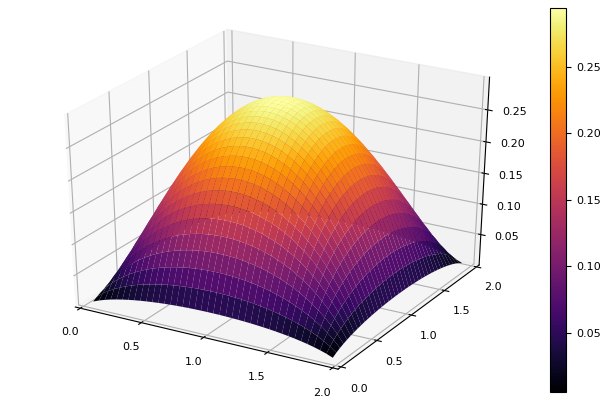

In [36]:
plot(gen_2D_positions_x(N, h), 
     gen_2D_positions_y(N, h),
    reroll(result,N), 
    st = [:surface], 
    xlims = (0,2),
    ylims = (0,2))